In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt, seaborn
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [3]:
sales = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/sales_train.csv',parse_dates=['date'], dtype={'date': 'str', 'date_block_num': 'int32', 'shop_id': 'int32', 'item_id': 'int32', 'item_price': 'float32', 'item_cnt_day': 'int32'})
shops = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/shops.csv',dtype={'shop_name': 'str', 'shop_id': 'int32'})
items = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/items.csv',dtype={'item_name': 'str', 'item_id': 'int32', 'item_category_id': 'int32'})
item_categories = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/item_categories.csv',dtype={'item_category_name': 'str', 'item_category_id': 'int32'})
test = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/test.csv',dtype={'ID': 'int32', 'shop_id': 'int32', 'item_id': 'int32'})

In [4]:
train = sales.join(items, on='item_id', rsuffix='_').join(shops, on='shop_id', rsuffix='_').join(item_categories, on='item_category_id', rsuffix='_').drop(['item_id_', 'shop_id_', 'item_category_id_'], axis=1)

In [5]:
test_shop_ids = test['shop_id'].unique()
test_item_ids = test['item_id'].unique()
lk_train = train[train['shop_id'].isin(test_shop_ids)]
lk_train = lk_train[lk_train['item_id'].isin(test_item_ids)]
train_monthly = lk_train[['date', 'date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'item_cnt_day']]
train_monthly.head().append(train_monthly.tail())

,date,date_block_num,shop_id,item_category_id,item_id,item_price,item_cnt_day
0,2013-02-01,0,59,37,22154,999.0,1
10,2013-03-01,0,25,55,2574,399.0,2
11,2013-05-01,0,25,55,2574,399.0,1
12,2013-07-01,0,25,55,2574,399.0,1
13,2013-08-01,0,25,55,2574,399.0,2
2935844,2015-10-10,33,25,55,7409,299.0,1
2935845,2015-09-10,33,25,55,7460,299.0,1
2935846,2015-10-14,33,25,55,7459,349.0,1
2935847,2015-10-22,33,25,57,7440,299.0,1
2935848,2015-03-10,33,25,55,7460,299.0,1


In [6]:
print(train_monthly.duplicated().any())
print('**'*30)
## 缺失值
print(train_monthly.isnull().sum())

True
************************************************************
date                0
date_block_num      0
shop_id             0
item_category_id    0
item_id             0
item_price          0
item_cnt_day        0
dtype: int64


In [7]:
train_monthly = train_monthly.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_category_id', 'item_id'], as_index=False)
train_monthly = train_monthly.agg({'item_price':['sum', 'mean'], 'item_cnt_day':['sum', 'mean','count']})
# Rename features.
train_monthly.columns = ['date_block_num', 'shop_id', 'item_category_id', 'item_id', 'item_price', 'mean_item_price', 'item_cnt', 'mean_item_cnt', 'transactions']
train_monthly.head().append(train_monthly.tail())

,date_block_num,shop_id,item_category_id,item_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions
0,0,2,2,5572,10730.000000,1532.857178,9,1.285714,7
1,0,2,2,5643,4775.209961,2387.604980,0,0.000000,2
2,0,2,5,5583,1188.300049,594.150024,2,1.000000,2
3,0,2,6,7893,5970.000000,1990.000000,3,1.000000,3
4,0,2,6,7894,1490.000000,1490.000000,1,1.000000,1
600154,33,59,75,5383,4390.000000,4390.000000,1,1.000000,1
600155,33,59,79,17717,8025.500000,802.549988,13,1.300000,10
600156,33,59,83,22087,357.000000,119.000000,6,2.000000,3
600157,33,59,83,22088,238.000000,119.000000,2,1.000000,2
600158,33,59,83,22091,179.000000,179.000000,1,1.000000,1


In [8]:
shop_ids = train_monthly['shop_id'].unique()
item_ids = train_monthly['item_id'].unique()
empty_df = []
for i in range(34):
    for shop in shop_ids:
        for item in item_ids:
            empty_df.append([i, shop, item])

empty_df = pd.DataFrame(empty_df, columns=['date_block_num','shop_id','item_id'])
train_monthly = pd.merge(empty_df, train_monthly, on=['date_block_num','shop_id','item_id'], how='left')
train_monthly.fillna(0, inplace=True)
train_monthly['year'] = train_monthly['date_block_num'].apply(lambda x: ((x//12) + 2013))
train_monthly['month'] = train_monthly['date_block_num'].apply(lambda x: (x % 12))

In [9]:
gp_month_mean = train_monthly.groupby(['month'], as_index=False)['item_cnt'].mean()
gp_month_sum = train_monthly.groupby(['month'], as_index=False)['item_cnt'].sum()
gp_category_mean = train_monthly.groupby(['item_category_id'], as_index=False)['item_cnt'].mean()
gp_category_sum = train_monthly.groupby(['item_category_id'], as_index=False)['item_cnt'].sum()
gp_shop_mean = train_monthly.groupby(['shop_id'], as_index=False)['item_cnt'].mean()
gp_shop_sum = train_monthly.groupby(['shop_id'], as_index=False)['item_cnt'].sum()

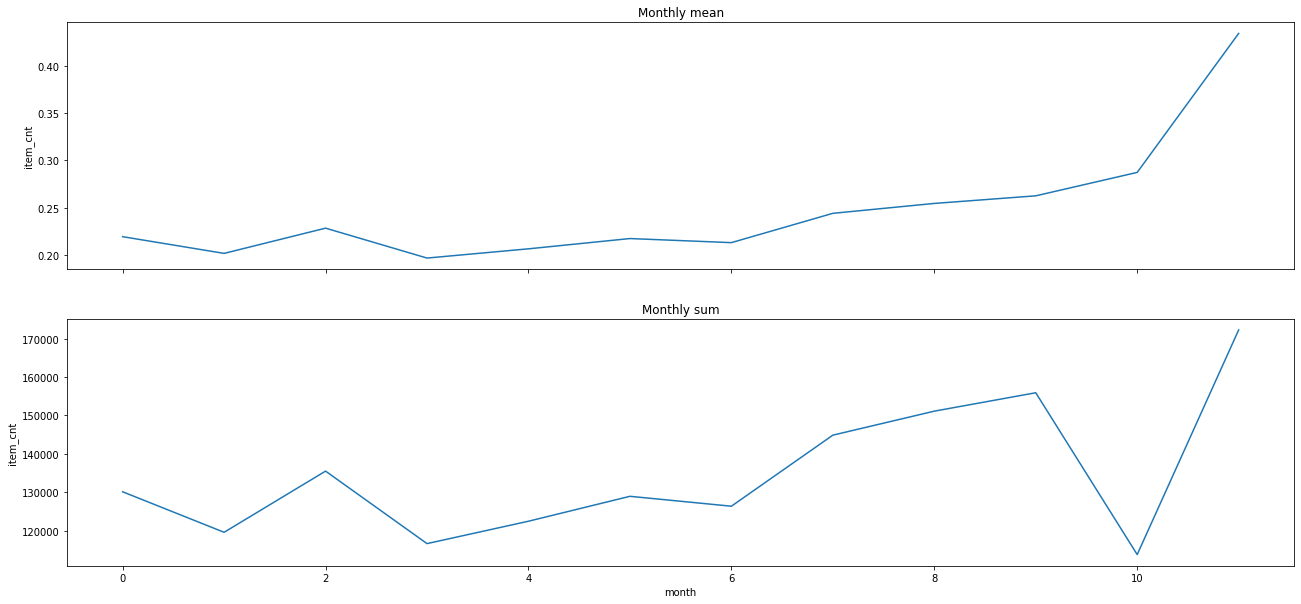

In [10]:
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.lineplot(x="month", y="item_cnt", data=gp_month_mean, ax=axes[0]).set_title("Monthly mean")
sns.lineplot(x="month", y="item_cnt", data=gp_month_sum, ax=axes[1]).set_title("Monthly sum")
plt.show()

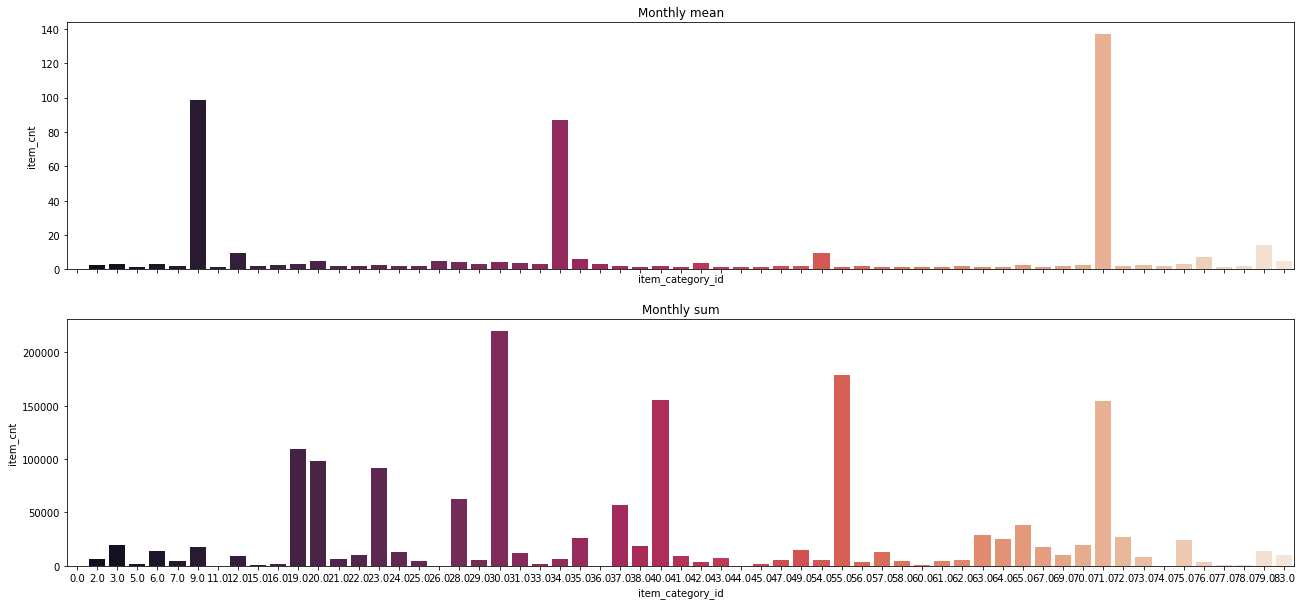

In [11]:
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.barplot(x="item_category_id", y="item_cnt", data=gp_category_mean, ax=axes[0], palette="rocket").set_title("Monthly mean")
sns.barplot(x="item_category_id", y="item_cnt", data=gp_category_sum, ax=axes[1], palette="rocket").set_title("Monthly sum")
plt.show()

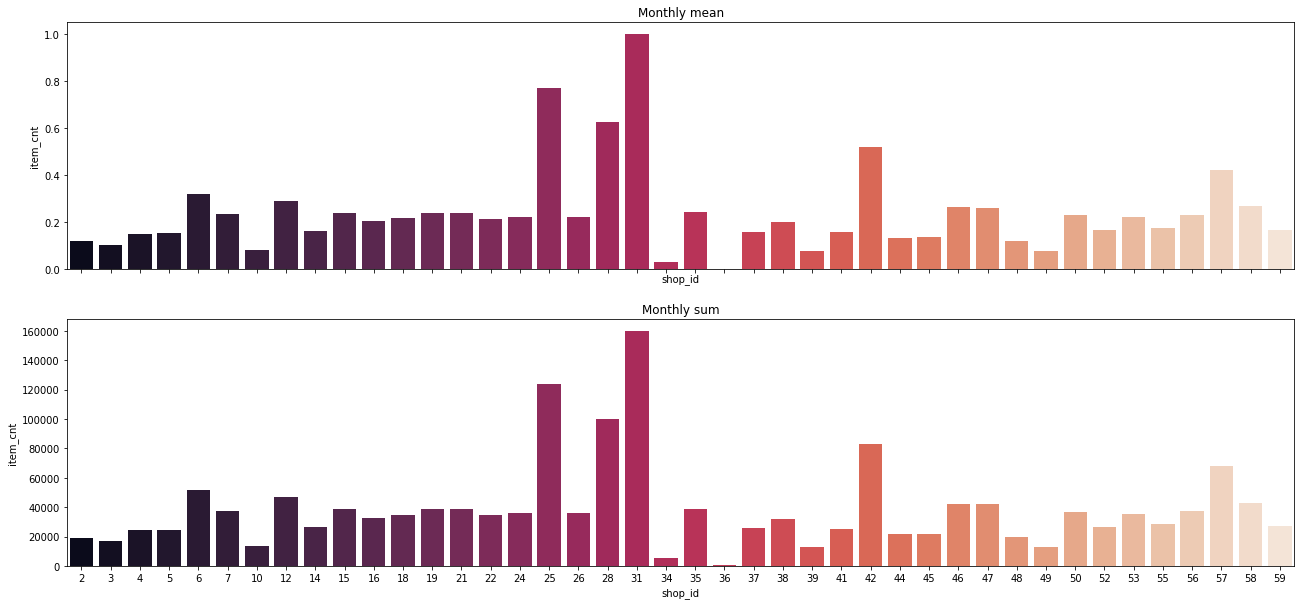

In [12]:
f, axes = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.barplot(x="shop_id", y="item_cnt", data=gp_shop_mean, ax=axes[0], palette="rocket").set_title("Monthly mean")
sns.barplot(x="shop_id", y="item_cnt", data=gp_shop_sum, ax=axes[1], palette="rocket").set_title("Monthly sum")
plt.show()

In [13]:
train_monthly = train_monthly.query('item_cnt >= 0 and item_cnt <= 20 and item_price < 300000')
train_monthly.head().append(train_monthly.tail())

,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,month
0,0,2,5572,2.0,10730.000000,1532.857178,9.0,1.285714,7.0,2013,0
1,0,2,5643,2.0,4775.209961,2387.604980,0.0,0.000000,2.0,2013,0
2,0,2,5583,5.0,1188.300049,594.150024,2.0,1.000000,2.0,2013,0
3,0,2,7893,6.0,5970.000000,1990.000000,3.0,1.000000,3.0,2013,0
4,0,2,7894,6.0,1490.000000,1490.000000,1.0,1.000000,1.0,2013,0
6734443,33,36,9103,0.0,0.000000,0.000000,0.0,0.000000,0.0,2015,9
6734444,33,36,9107,0.0,0.000000,0.000000,0.0,0.000000,0.0,2015,9
6734445,33,36,5704,0.0,0.000000,0.000000,0.0,0.000000,0.0,2015,9
6734446,33,36,12733,0.0,0.000000,0.000000,0.0,0.000000,0.0,2015,9
6734447,33,36,15925,0.0,0.000000,0.000000,0.0,0.000000,0.0,2015,9


In [14]:
train_monthly['item_cnt_month'] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_id'])['item_cnt'].shift(-1)   #下个月的销量

In [15]:
train_monthly['item_price_unit'] = train_monthly['item_price'] // train_monthly['item_cnt']
train_monthly['item_price_unit'].fillna(0, inplace=True)

In [16]:
gp_item_price = train_monthly.sort_values('date_block_num').groupby(['item_id'], as_index=False).agg({'item_price':[np.min, np.max]})
gp_item_price.columns = ['item_id', 'hist_min_item_price', 'hist_max_item_price']
train_monthly = pd.merge(train_monthly, gp_item_price, on='item_id', how='left')
train_monthly['price_increase'] = train_monthly['item_price'] - train_monthly['hist_min_item_price']
train_monthly['price_decrease'] = train_monthly['hist_max_item_price'] - train_monthly['item_price']

In [17]:
# Min value
f_min = lambda x: x.rolling(window=3, min_periods=1).min()
# Max value
f_max = lambda x: x.rolling(window=3, min_periods=1).max()
# Mean value
f_mean = lambda x: x.rolling(window=3, min_periods=1).mean()
# Standard deviation
f_std = lambda x: x.rolling(window=3, min_periods=1).std()
function_list = [f_min, f_max, f_mean, f_std]
function_name = ['min', 'max', 'mean', 'std']
for i in range(len(function_list)):
    train_monthly[('item_cnt_%s' % function_name[i])] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_category_id', 'item_id'])['item_cnt'].apply(function_list[i])
# Fill the empty std features with 0
train_monthly['item_cnt_std'].fillna(0, inplace=True)

In [18]:
lag_list = [1, 2, 3]
for lag in lag_list:
    ft_name = ('item_cnt_shifted%s' % lag)
    train_monthly[ft_name] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_category_id', 'item_id'])['item_cnt'].shift(lag)
    # Fill the empty shifted features with 0
    train_monthly[ft_name].fillna(0, inplace=True)

In [19]:
train_monthly['item_trend'] = train_monthly['item_cnt']
for lag in lag_list:
    ft_name = ('item_cnt_shifted%s' % lag)
    train_monthly['item_trend'] -= train_monthly[ft_name]

train_monthly['item_trend'] /= len(lag_list) + 1

In [20]:
train_set = train_monthly.query('date_block_num >= 3 and date_block_num < 28').copy()
validation_set = train_monthly.query('date_block_num >= 28 and date_block_num < 33').copy()
test_set = train_monthly.query('date_block_num == 33').copy()
train_set.dropna(subset=['item_cnt_month'], inplace=True)
validation_set.dropna(subset=['item_cnt_month'], inplace=True)
train_set.dropna(inplace=True)
validation_set.dropna(inplace=True)

In [21]:
# Shop mean encoding.
gp_shop_mean = train_set.groupby(['shop_id']).agg({'item_cnt_month': ['mean']})
gp_shop_mean.columns = ['shop_mean']
gp_shop_mean.reset_index(inplace=True)
# Item mean encoding.
gp_item_mean = train_set.groupby(['item_id']).agg({'item_cnt_month': ['mean']})
gp_item_mean.columns = ['item_mean']
gp_item_mean.reset_index(inplace=True)
# Shop with item mean encoding.
gp_shop_item_mean = train_set.groupby(['shop_id', 'item_id']).agg({'item_cnt_month': ['mean']})
gp_shop_item_mean.columns = ['shop_item_mean']
gp_shop_item_mean.reset_index(inplace=True)
# Year mean encoding.
gp_year_mean = train_set.groupby(['year']).agg({'item_cnt_month': ['mean']})
gp_year_mean.columns = ['year_mean']
gp_year_mean.reset_index(inplace=True)
# Month mean encoding.
gp_month_mean = train_set.groupby(['month']).agg({'item_cnt_month': ['mean']})
gp_month_mean.columns = ['month_mean']
gp_month_mean.reset_index(inplace=True)
# Add meand encoding features to train set.
train_set = pd.merge(train_set, gp_shop_mean, on=['shop_id'], how='left')
train_set = pd.merge(train_set, gp_item_mean, on=['item_id'], how='left')
train_set = pd.merge(train_set, gp_shop_item_mean, on=['shop_id', 'item_id'], how='left')
train_set = pd.merge(train_set, gp_year_mean, on=['year'], how='left')
train_set = pd.merge(train_set, gp_month_mean, on=['month'], how='left')
# Add meand encoding features to validation set.
validation_set = pd.merge(validation_set, gp_shop_mean, on=['shop_id'], how='left')
validation_set = pd.merge(validation_set, gp_item_mean, on=['item_id'], how='left')
validation_set = pd.merge(validation_set, gp_shop_item_mean, on=['shop_id', 'item_id'], how='left')
validation_set = pd.merge(validation_set, gp_year_mean, on=['year'], how='left')
validation_set = pd.merge(validation_set, gp_month_mean, on=['month'], how='left')

In [22]:
X_train = train_set.drop(['item_cnt_month', 'date_block_num'], axis=1)
Y_train = train_set['item_cnt_month'].astype(int)
X_validation = validation_set.drop(['item_cnt_month', 'date_block_num'], axis=1)
Y_validation = validation_set['item_cnt_month'].astype(int)

In [23]:
int_features = ['shop_id', 'item_id', 'year', 'month']

X_train[int_features] = X_train[int_features].astype('int32')
X_validation[int_features] = X_validation[int_features].astype('int32')

In [24]:
latest_records = pd.concat([train_set, validation_set]).drop_duplicates(subset=['shop_id', 'item_id'], keep='last')
#latest_records为每个shop_id,item_id组合的最新的特征记录，如果每验证集的最后一个月出现了某种组合，则该组合特征记录一定是在最有一个月，如果最后一个月没有，则找最近的一个月份的
#特征记录
X_test = pd.merge(test, latest_records, on=['shop_id', 'item_id'], how='left', suffixes=['', '_'])  #让每个组合拥有最近的记录
X_test.head().append(X_test.tail())
X_test['year'] = 2015
X_test['month'] = 9
X_test.drop('item_cnt_month', axis=1, inplace=True)
X_test[int_features] = X_test[int_features].astype('int32')
X_test = X_test[X_train.columns]

In [25]:
sets = [X_train, X_validation, X_test]
for dataset in sets:
    for shop_id in dataset['shop_id'].unique():
        for column in dataset.columns:
            shop_median = dataset[(dataset['shop_id'] == shop_id)][column].median()
            dataset.loc[(dataset[column].isnull()) & (dataset['shop_id'] == shop_id), column] = shop_median

# Fill remaining missing values on test set with mean.
X_test.fillna(X_test.mean(), inplace=True)

In [26]:
X_train.drop(['item_category_id'], axis=1, inplace=True)
X_validation.drop(['item_category_id'], axis=1, inplace=True)
X_test.drop(['item_category_id'], axis=1, inplace=True)

In [29]:
X_train

,shop_id,item_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,month,item_price_unit,...,item_cnt_std,item_cnt_shifted1,item_cnt_shifted2,item_cnt_shifted3,item_trend,shop_mean,item_mean,shop_item_mean,year_mean,month_mean
0,2,5572.0,2980.0,1490.0,2.0,1.0,2.0,2013,3,1490.0,...,0.577350,1.0,1.0,9.0,-2.25,0.097844,1.004766,0.84,0.135030,0.157306
1,2,5643.0,0.0,0.0,0.0,0.0,0.0,2013,3,0.0,...,0.000000,0.0,0.0,0.0,0.00,0.097844,1.818702,1.84,0.135030,0.157306
2,2,5583.0,0.0,0.0,0.0,0.0,0.0,2013,3,0.0,...,0.000000,0.0,0.0,0.0,0.00,0.097844,0.589524,0.04,0.135030,0.157306
3,2,7893.0,9350.0,1870.0,5.0,1.0,5.0,2013,3,1870.0,...,2.081666,1.0,2.0,3.0,-0.25,0.097844,3.038388,3.12,0.135030,0.157306
4,2,7894.0,0.0,0.0,0.0,0.0,0.0,2013,3,0.0,...,0.000000,0.0,0.0,0.0,0.00,0.097844,3.670837,1.68,0.135030,0.157306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4946770,36,9103.0,0.0,0.0,0.0,0.0,0.0,2015,3,0.0,...,0.000000,0.0,0.0,0.0,0.00,0.000000,0.000000,0.00,0.224905,0.157306
4946771,36,9107.0,0.0,0.0,0.0,0.0,0.0,2015,3,0.0,...,0.000000,0.0,0.0,0.0,0.00,0.000000,0.000000,0.00,0.224905,0.157306
4946772,36,5704.0,0.0,0.0,0.0,0.0,0.0,2015,3,0.0,...,0.000000,0.0,0.0,0.0,0.00,0.000000,0.000000,0.00,0.224905,0.157306
4946773,36,12733.0,0.0,0.0,0.0,0.0,0.0,2015,3,0.0,...,0.000000,0.0,0.0,0.0,0.00,0.000000,0.000000,0.00,0.224905,0.157306


In [30]:
X_validation

,shop_id,item_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,month,item_price_unit,...,item_cnt_std,item_cnt_shifted1,item_cnt_shifted2,item_cnt_shifted3,item_trend,shop_mean,item_mean,shop_item_mean,year_mean,month_mean
0,2,5572.0,1590.0,1590.00,1.0,1.0,1.0,2015,4,1590.0,...,6.580175e-08,1.0,1.0,1.0,-0.5,0.097844,1.004766,0.84,0.224905,0.140792
1,2,5643.0,0.0,0.00,0.0,0.0,0.0,2015,4,0.0,...,0.000000e+00,0.0,0.0,0.0,0.0,0.097844,1.818702,1.84,0.224905,0.140792
2,2,5583.0,0.0,0.00,0.0,0.0,0.0,2015,4,0.0,...,0.000000e+00,0.0,0.0,0.0,0.0,0.097844,0.589524,0.04,0.224905,0.140792
3,2,7893.0,0.0,0.00,0.0,0.0,0.0,2015,4,0.0,...,0.000000e+00,0.0,0.0,0.0,0.0,0.097844,3.038388,3.12,0.224905,0.140792
4,2,7894.0,4579.5,2289.75,2.0,1.0,2.0,2015,4,2289.0,...,2.081666e+00,1.0,5.0,2.0,-1.5,0.097844,3.670837,1.68,0.224905,0.140792
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
989406,36,9103.0,0.0,0.00,0.0,0.0,0.0,2015,8,0.0,...,0.000000e+00,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00,0.224905,0.167111
989407,36,9107.0,0.0,0.00,0.0,0.0,0.0,2015,8,0.0,...,0.000000e+00,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00,0.224905,0.167111
989408,36,5704.0,0.0,0.00,0.0,0.0,0.0,2015,8,0.0,...,0.000000e+00,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00,0.224905,0.167111
989409,36,12733.0,0.0,0.00,0.0,0.0,0.0,2015,8,0.0,...,0.000000e+00,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00,0.224905,0.167111


In [31]:
X_test

,shop_id,item_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,month,item_price_unit,...,item_cnt_std,item_cnt_shifted1,item_cnt_shifted2,item_cnt_shifted3,item_trend,shop_mean,item_mean,shop_item_mean,year_mean,month_mean
0,5,5037,749.5,749.5,1.0,1.0,1.0,2015,9,749.0,...,1.154701,3.0,1.0,1.0,-1.00,0.134691,0.703527,0.28,0.224905,0.167111
1,5,5320,0.0,0.0,0.0,0.0,0.0,2015,9,0.0,...,0.000000,0.0,0.0,0.0,0.00,0.134691,0.053333,0.00,0.224905,0.167111
2,5,5233,2997.0,999.0,3.0,1.0,3.0,2015,9,999.0,...,1.000000,1.0,2.0,3.0,-0.75,0.134691,0.071429,0.12,0.224905,0.167111
3,5,5232,0.0,0.0,0.0,0.0,0.0,2015,9,0.0,...,0.000000,0.0,0.0,0.0,0.00,0.134691,0.000000,0.00,0.224905,0.167111
4,5,5268,0.0,0.0,0.0,0.0,0.0,2015,9,0.0,...,0.000000,0.0,0.0,0.0,0.00,0.134691,0.053333,0.00,0.224905,0.167111
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
214195,45,18454,0.0,0.0,0.0,0.0,0.0,2015,9,0.0,...,0.000000,0.0,0.0,0.0,0.00,0.120920,0.403810,0.32,0.224905,0.167111
214196,45,16188,0.0,0.0,0.0,0.0,0.0,2015,9,0.0,...,0.000000,0.0,0.0,0.0,0.00,0.120920,0.000000,0.00,0.224905,0.167111
214197,45,15757,0.0,0.0,0.0,0.0,0.0,2015,9,0.0,...,0.000000,0.0,0.0,0.0,0.00,0.120920,0.230476,0.24,0.224905,0.167111
214198,45,19648,0.0,0.0,0.0,0.0,0.0,2015,9,0.0,...,0.000000,0.0,0.0,0.0,0.00,0.120920,0.030476,0.00,0.224905,0.167111


In [27]:
from xgboost import XGBRegressor
from xgboost import plot_importance
import time

xgb_features = ['item_cnt','item_cnt_mean', 'item_cnt_std', 'item_cnt_shifted1', 
                'item_cnt_shifted2', 'item_cnt_shifted3', 'shop_mean', 
                'shop_item_mean', 'item_trend', 'mean_item_cnt']
                
xgb_train = X_train[xgb_features]
xgb_val = X_validation[xgb_features]
xgb_test = X_test[xgb_features]
xgb_model = XGBRegressor(max_depth=8, 
                         n_estimators=500, 
                         min_child_weight=1000,  
                         colsample_bytree=0.7, 
                         subsample=0.7, 
                         eta=0.3, 
                         seed=0)
xgb_model.fit(xgb_train, 
              Y_train, 
              eval_metric="rmse", 
              eval_set=[(xgb_train, Y_train), (xgb_val, Y_validation)], 
              verbose=20, 
              early_stopping_rounds=20)

[11:26:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[11:26:26] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:0.937611	validation_1-rmse:0.928068
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[20]	validation_0-rmse:0.684521	validation_1-rmse:0.790473
Stopping. Best iteration:
[17]	validation_0-rmse:0.690213	validation_1-rmse:0.787446



XGBRegressor(colsample_bytree=0.7, eta=0.3, max_depth=8, min_child_weight=1000,
             n_estimators=500, seed=0, subsample=0.7)

In [28]:
xgb_model.save_model('/content/gdrive/MyDrive/Colab Notebooks/xgb_model.h5')

In [29]:
Y_pred = xgb_model.predict(xgb_val).clip(0, 20)
Y_test = xgb_model.predict(xgb_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('/content/gdrive/MyDrive/Colab Notebooks/xgb_sub_v4.csv', index=False)

In [30]:
dl = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/xgb_sub_v4.csv')
dl

,ID,item_cnt_month
0,0,0.432040
1,1,0.088752
2,2,0.557153
3,3,0.088752
4,4,0.088752
...,...,...
214195,214195,0.252316
214196,214196,0.088970
214197,214197,0.216733
214198,214198,0.088970


In [31]:
pred_model = XGBRegressor()
pred_model.load_model('/content/gdrive/MyDrive/Colab Notebooks/xgb_model.h5')
Y_p = pred_model.predict(xgb_val).clip(0, 20)
Y_t = pred_model.predict(xgb_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_t
})
submission.to_csv('/content/gdrive/MyDrive/Colab Notebooks/xgb_sub_v5_.csv', index=False)

[11:34:41] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [34]:
dt = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/xgb_sub_v5_.csv')
dt

,ID,item_cnt_month
0,0,0.295253
1,1,0.013107
2,2,0.312716
3,3,0.013107
4,4,0.013107
...,...,...
214195,214195,0.244828
214196,214196,0.013217
214197,214197,0.193615
214198,214198,0.013217


In [36]:
X_train.columns

Index(['shop_id', 'item_id', 'item_price', 'mean_item_price', 'item_cnt',
       'mean_item_cnt', 'transactions', 'year', 'month', 'item_price_unit',
       'hist_min_item_price', 'hist_max_item_price', 'price_increase',
       'price_decrease', 'item_cnt_min', 'item_cnt_max', 'item_cnt_mean',
       'item_cnt_std', 'item_cnt_shifted1', 'item_cnt_shifted2',
       'item_cnt_shifted3', 'item_trend', 'shop_mean', 'item_mean',
       'shop_item_mean', 'year_mean', 'month_mean'],
      dtype='object')